### 更精细的山体模型

##### 表1 实验厅的地理信息

根据三角测算，其坐标为：

| EH | longitude | latitude | rock coverage | altitude|
|----|-----|----|----|----|
|EH1 | 114.545072 | 22.600338| 93m  |-21.79m |
|EH2 | 114.548871 | 22.608738| 100m |  4.44m |
|EH3 | 114.540537 | 22.614854| 324m  | 10.07m |

In [51]:
from PIL import Image

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import RegularGridInterpolator
from scipy.constants import degree

import gc

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geopy.distance import geodesic

# From https://www.gscloud.cn/sources/accessdata/310?pid=302
MAPxcentre = 114.5
MAPycentre = 22.5

MAPwb = 113.9998611
MAPeb = 115.0001389
MAPnb = 23.0001389
MAPsb = 21.9998611

# From https://map.bmcx.com/
MAPEH1 = (114.545072 , 22.600338)
MAPEH2 = (114.548871 , 22.608738)
MAPEH3 = (114.540537 , 22.614854)

MAPzEH1 = -21.79
MAPzEH2 = 4.44
MAPzEH3 = 10.07

MAPRA_BG1 = (114.54271,22.59796)
MAPRA_BG2 = (114.54351,22.59780)
MAPRA_LA1 = (114.55092,22.60499)
MAPRA_LA2 = (114.55151,22.60564)
MAPRA_LA3 = (114.55365,22.60850)
MAPRA_LA4 = (114.55428,22.60907)

rho_rock = 2.6 #g/cm^3
epsilon_mu = 510 #GeV
pisai = 3.5e5


# Calculate the distance
def hDistance(tup1,tup2): return geodesic((tup1[-1],tup1[0]),(tup2[-1],tup2[0])).meters

xscale = hDistance((MAPwb,22.5),(MAPeb,22.5))/(MAPwb - MAPeb)
yscale = hDistance((114.5,MAPnb),(114.5,MAPsb))/(MAPnb-MAPsb)

In [36]:
img = Image.open('ASTGTMV003_N22E114_dem.tif')
imgArray = np.array(img)
del img
gc.collect()

xsize,ysize = np.shape(imgArray)
xrange = np.linspace(0,1,xsize)*(MAPeb-MAPwb) + MAPwb
yrange = np.linspace(0,1,ysize)*(-MAPnb+MAPsb) + MAPnb

interp2d = RegularGridInterpolator((xrange,yrange),imgArray.T,method='linear')

def transformXYZ2RTP(tup,loc,z):
    xr = hDistance(loc,(tup[0],loc[1]))
    yr = hDistance(loc,(loc[0],tup[1]))
    zr = interp2d(tup)-z
    theta = np.arctan(np.sqrt(xr**2+yr**2)/zr)
    phi = np.arccos(xr/(np.sqrt(xr**2+yr**2)))
    rho = np.sqrt(xr**2+yr**2+zr**2)
    Eth = epsilon_mu*(np.exp((rho*1e2)*rho_rock/pisai) - 1)

    return rho,theta,phi,Eth

def transformRTP(theta,phi,loc,z):
    rho_stop = 1e4 #10km
    rho = 10
    z_test = rho*np.cos(theta)
    h_test = interp2d(loc)

    while ((z_test + z) < h_test):
        x_test = -rho*np.sin(theta)*np.cos(phi)/xscale + loc[0]
        y_test = rho*np.sin(theta)*np.sin(phi)/yscale + loc[1]
        z_test = rho*np.cos(theta)
        h_test = interp2d((x_test,y_test))
        rho += 1
        if (rho > rho_stop): break

    Eth = epsilon_mu*(np.exp((rho*1e2)*rho_rock/pisai) - 1)
    return Eth

#transformXYZ2RTP(MAPEH1,MAPEH2,-21.79)

transformRTP(np.deg2rad(30),0,MAPEH1,MAPzEH1)

np.float64(42.19234684156967)

##### 图1 EH1的log(Eth)角分布雷达图

Text(0.5, 1.0, 'EH1')

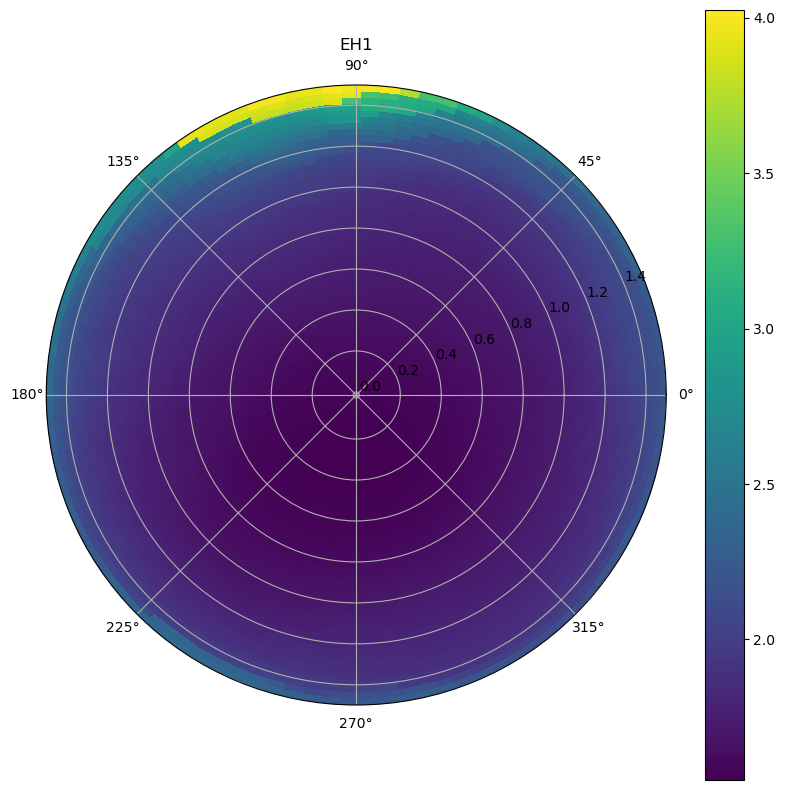

In [37]:
theta_range = np.deg2rad(np.linspace(0,85,50))
phi_range = np.deg2rad(np.linspace(0,360,100))
theta_grid, phi_grid = np.meshgrid(theta_range,phi_range)
points = np.array([theta_grid.ravel(),phi_grid.ravel()]).T

Eths = np.zeros(np.shape(theta_range)[0]*np.shape(phi_range)[0])
for i,p in enumerate(points):
    Eths[i] = transformRTP(*p,MAPEH1,MAPzEH1)
Eths = Eths.reshape(np.shape(theta_grid))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='polar')

pm = ax.pcolormesh(phi_grid,theta_grid,np.log10(Eths))
fig.colorbar(pm,ax=ax)
ax.set_title('EH1')

##### 图2 EH2的log(Eth)角分布雷达图

Text(0.5, 1.0, 'EH2')

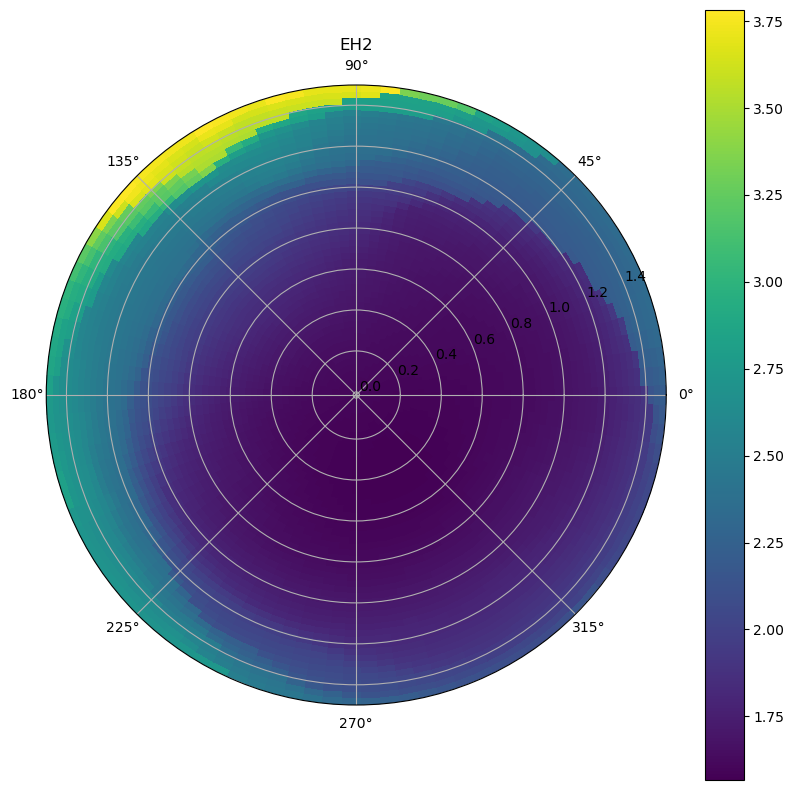

In [38]:
Eths = np.zeros(np.shape(theta_range)[0]*np.shape(phi_range)[0])
for i,p in enumerate(points):
    Eths[i] = transformRTP(*p,MAPEH2,MAPzEH2)
Eths = Eths.reshape(np.shape(theta_grid))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='polar')
ax.invert_xaxis()

pm = ax.pcolormesh(phi_grid,theta_grid,np.log10(Eths))
fig.colorbar(pm,ax=ax)
ax.set_title('EH2')

##### 图3 EH3的log(Eth)角分布雷达图

Text(0.5, 1.0, 'EH3')

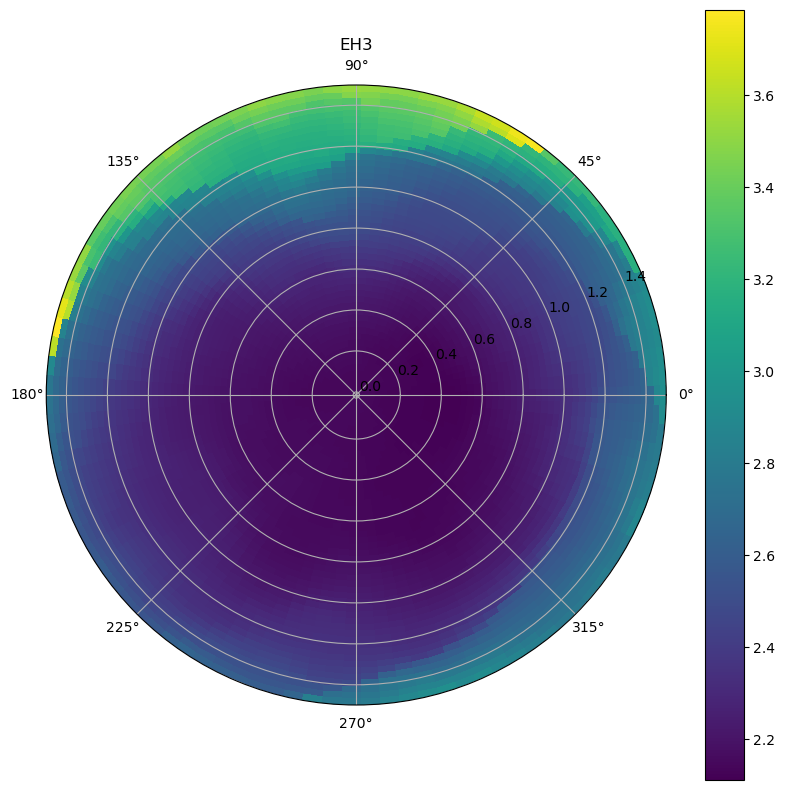

In [39]:
Eths = np.zeros(np.shape(theta_range)[0]*np.shape(phi_range)[0])
for i,p in enumerate(points):
    Eths[i] = transformRTP(*p,MAPEH3,MAPzEH3)
Eths = Eths.reshape(np.shape(theta_grid))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='polar')
ax.invert_xaxis()

pm = ax.pcolormesh(phi_grid,theta_grid,np.log10(Eths))
fig.colorbar(pm,ax=ax)
ax.set_title('EH3')

### 更精细的大气模型

由于ERA5的最小气压层只有100hPa, 这是不太符合我们的要求的。我们想把ERA5的数据和NRLMSISE-00拼起来。要做的第一件事是确定ERA5如何获取高度信息。

#### ERA5 的高度信息

Geopotential：

This parameter is the gravitational potential energy of a unit mass, at a particular location, relative to mean sea level. It is also the amount of work that would have to be done, against the force of gravity, to lift a unit mass to that location from mean sea level. The geopotential height can be calculated by dividing the geopotential by the Earth's gravitational acceleration, g (=9.80665 m s-2). The geopotential height plays an important role in synoptic meteorology (analysis of weather patterns). Charts of geopotential height plotted at constant pressure levels (e.g., 300, 500 or 850 hPa) can be used to identify weather systems such as cyclones, anticyclones, troughs and ridges. At the surface of the Earth, this parameter shows the variations in geopotential (height) of the surface, and is often referred to as the orography.

该参数是单位质量在特定位置相对于平均海平面的重力势能。这也是在重力作用下，将单位质量从平均海平面提升到该位置所必须做的工作量。位势高度可以通过将位势除以地球的引力加速度 g （=9.80665 m s-2） 来计算。位势高度在天气气象学（天气模式分析）中起着重要作用。在恒定压力水平（例如 300、500 或 850 hPa）下绘制的位势高度图表可用于识别气旋、反气旋、槽和山脊等天气系统。在地球表面，该参数显示地表位势（高度）的变化，通常称为地形。

#### ERA5 的密度信息

ERA5 不提供各海拔层的密度信息，哪怕是间接的信息也没有。为此我们需要额外的信息获取不同区域的密度。

ERA5提供的100pa以及以下的层，按照理想气体的状态方程进行估计，是没有什么问题的。但是对于高层大气，大气组分会发生变化。在高层大气，甚至不能达到热力学平衡状态，热力学第零定律不再适用，不能定义热平衡温度。按照USStd这帮人的计算，100km以下，大气的摩尔质量不会有大变化。我们就可以用：
$$
\rho = \frac{pM}{RT}
$$
来计算其密度。所以我们只需要三个变量，即压强，密度，温度，就可以满足我们计算的需要。

在这里我们读取2024年10月15日数据，自变量为从1到1000的所有47层大气数据。截取中国全境，从北纬60度到南维20度；东经70度到东经150度的范围。

#### 读取ERA5的温度和重力势数据

In [41]:
import os
import zipfile
import cdsapi
import xarray as xr

dayRequest = 15
monthRequest = 10
yearRequest = 2025
dateStr = f'{yearRequest}{monthRequest}{dayRequest}'
currentPath = os.getcwd()
zipPath = currentPath + f'/data/{dateStr}.zip'

try: 
    with zipfile.ZipFile(zipPath,'r') as z:
        fileList = z.namelist()
        print(f'{fileList}')
        os.mkdir(currentPath+f'/data/{dateStr}')
        z.extractall(currentPath+f'/data/{dateStr}/')
        geopDataSet = xr.open_dataset(currentPath+f'/data/{dateStr}/{fileList[0]}',engine='netcdf4')
        tempDataSet = xr.open_dataset(currentPath+f'/data/{dateStr}/{fileList[1]}',engine='netcdf4')
    os.remove(zipPath)
    
except FileExistsError:pass
except FileNotFoundError:
    dataset = "derived-era5-pressure-levels-daily-statistics"
    request = {
    "product_type": "reanalysis",
    "variable": [
        "geopotential",
        "temperature"
    ],
    "year": "2024",
    "month": ["10"],
    "day": ["15"],
    "pressure_level": [
        "1", "2", "3",
        "5", "7", "10",
        "20", "30", "50",
        "70", "100", "125",
        "150", "175", "200",
        "225", "250", "300",
        "350", "400", "450",
        "500", "550", "600",
        "650", "700", "750",
        "775", "800", "825",
        "850", "875", "900",
        "925", "950", "975",
        "1000"
    ],
    "daily_statistic": "daily_mean",
    "time_zone": "utc+08:00",
    "frequency": "6_hourly",
    "area": [60, 70, -20, 150]
}
    client = cdsapi.Client()
    client.retrieve(dataset, request).download(zipPath)


['geopotential_stream-oper_daily-mean.nc', 'temperature_0_daily-mean.nc']


In [42]:
geopDataSet

<xarray.Dataset> Size: 15MB
Dimensions:         (valid_time: 1, pressure_level: 37, latitude: 321,
                     longitude: 321)
Coordinates:
    number          int64 8B ...
  * pressure_level  (pressure_level) float64 296B 1e+03 975.0 950.0 ... 2.0 1.0
  * latitude        (latitude) float64 3kB 60.0 59.75 59.5 ... -19.75 -20.0
  * longitude       (longitude) float64 3kB 70.0 70.25 70.5 ... 149.8 150.0
  * valid_time      (valid_time) datetime64[ns] 8B 2024-10-15
Data variables:
    z               (valid_time, pressure_level, latitude, longitude) float32 15MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-19T12:55 GRIB to CDM+CF via cfgrib-0.9.1...

##### 图4 大范围大气各层的温度分布图

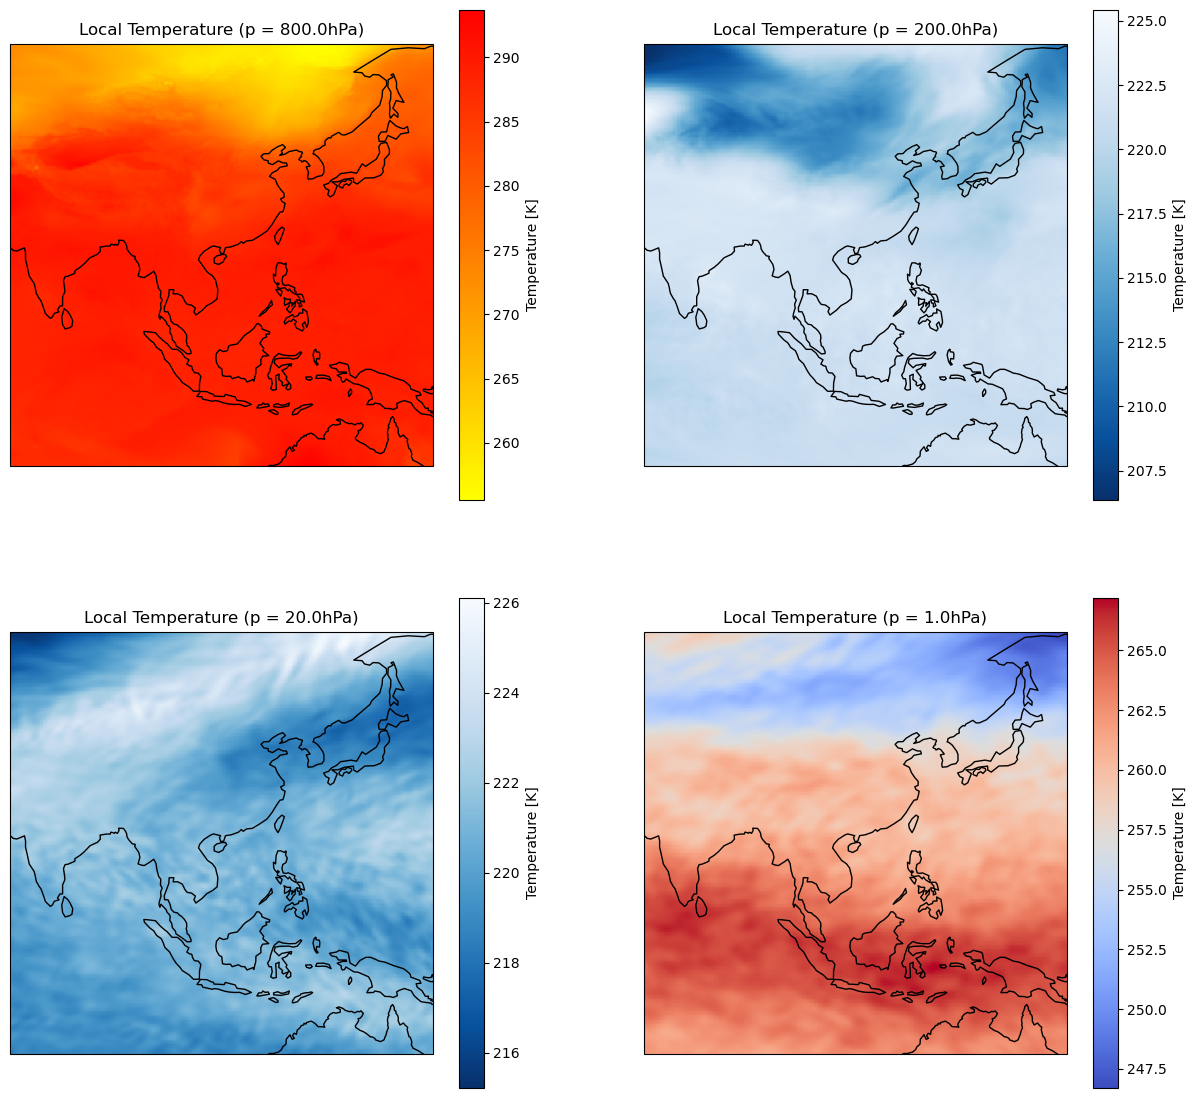

In [95]:
temperature = tempDataSet['t']

fig = plt.figure(figsize=(15,14))
axs = []
for i in range(4):
    axs.append(fig.add_subplot(221+i,projection=ccrs.PlateCarree()))
    #axs[i].set_extent([70.,150.,60.,-20.])

temperatureih = temperature.sel(pressure_level = 800)
temperatureih.plot(ax=axs[0],cmap='autumn_r')
temperatureih = temperature.sel(pressure_level = 200)
temperatureih.plot(ax=axs[1],cmap='Blues_r')
temperatureih = temperature.sel(pressure_level = 20)
temperatureih.plot(ax=axs[2],cmap='Blues_r')
temperatureih = temperature.sel(pressure_level = 1)
temperatureih.plot(ax=axs[3],cmap='coolwarm')
for i,p in enumerate([800.,200.,20.,1]):
    axs[i].set_xlabel('Longitude')
    axs[i].set_ylabel('Latitude')
    axs[i].set_title(f'Local Temperature (p = {p:.1f}hPa)')
    axs[i].add_feature(cfeature.COASTLINE)

##### 图5 大范围大气单层的重力势分布图

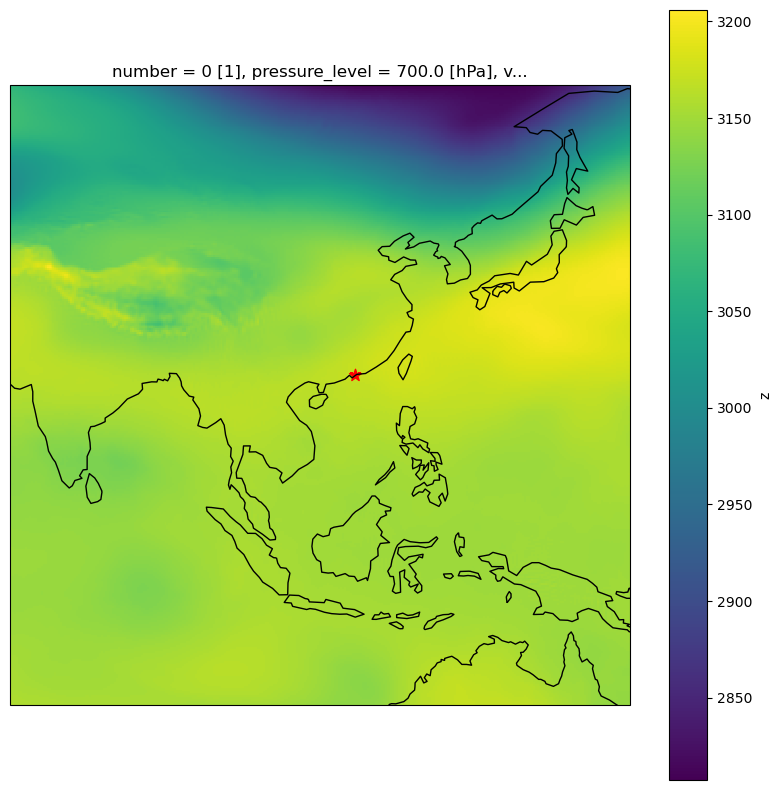

In [128]:
altitude = geopDataSet['z']
z800 = altitude.sel(pressure_level = 700)/9.80665

fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.grid()

z800.plot(ax = ax)
ax.scatter(*MAPEH1,marker='*',c='r',s=80)
ax.add_feature(cfeature.COASTLINE)


#### 90度天顶角覆盖范围

由于地球存在曲率，90度的天顶角不能延伸至无限远处。R+h对应的球冠边缘对应地球经纬度的一个边界。在切平面上，这个圆的半径大小为：
$$
r = \sqrt{(R+h)^2 - R^2}
$$

例如，10km球冠对应的切平面投影半径为358km, 而100km球冠对应的切平面投影半径为1136km。我们直观得将其投影到地球表面上，参数方程：
$$
\Delta \theta_x = arctan(\frac{\sqrt{2hR+h^2}}{R}cos\phi)
$$

$$
\Delta \theta_y = arctan(\frac{\sqrt{2hR+h^2}}{R}sin\phi)
$$


##### 图6 不同层高球冠投影范围示意图

10 km Circle has radius 357.10 km
100 km Circle has radius 1133.23 km
200 km Circle has radius 1608.85 km


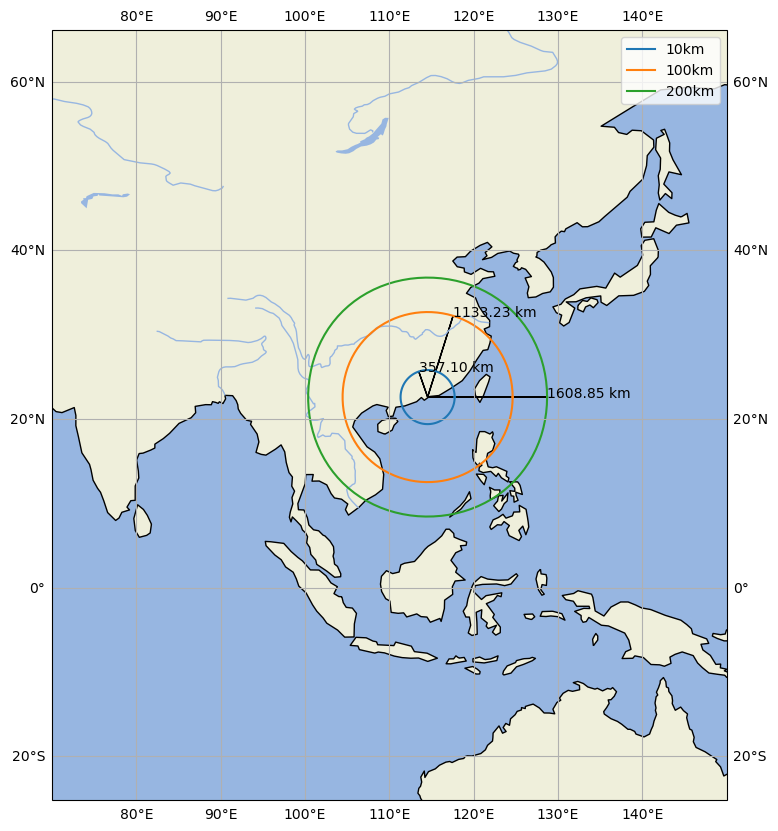

In [157]:
def drawCircle(h):
    R = 6371
    phis = np.deg2rad(np.linspace(0,360,100))
    r = np.sqrt(2*h*R+h**2)
    fractor = r/R
    xcircle = np.rad2deg(np.arctan(fractor*np.cos(phis))) + MAPEH1[0]
    ycircle = np.rad2deg(np.arctan(fractor*np.sin(phis))) + MAPEH1[1]
    print(f'{h} km Circle has radius {r :.2f} km')
    return xcircle,ycircle,r
xcircle10,ycircle10,r10 = drawCircle(10)
xcircle100,ycircle100,r100 = drawCircle(100)
xcircle200,ycircle200,r200 = drawCircle(200)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.set_extent([70.,150.,60.,-20.])

ax.plot(xcircle10,ycircle10,label = '10km')
ax.arrow(*MAPEH1,dx=-MAPEH1[0]+xcircle10[30],dy=-MAPEH1[1]+ycircle10[30])
ax.text(xcircle10[30],ycircle10[30],s=f'{r10:.2f} km')

ax.plot(xcircle100,ycircle100,label = '100km')
ax.arrow(*MAPEH1,dx=-MAPEH1[0]+xcircle100[20],dy=-MAPEH1[1]+ycircle100[20])
ax.text(xcircle100[20],ycircle100[20],s=f'{r100:.2f} km')

ax.plot(xcircle200,ycircle200,label = '200km')
ax.arrow(*MAPEH1,dx=-MAPEH1[0]+xcircle200[0],dy=-MAPEH1[1]+ycircle200[0])
ax.text(xcircle200[0],ycircle200[0],s=f'{r200:.2f} km')

ax.legend()

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels=True)

plt.show()

可见我们其实用不到如此大范围的气象资料，按照100km的高度，其实向北最多到郑州，往南到中沙群岛或者南沙，往西不超过贵阳，往东到冲绳就可以了。基本上就是华南，南海北部的气象资料就足够年。按照经纬度来算也就是$N 0\degree \to N 40\degree$, $E 100\degree \to E 130\degree$

#### 覆盖范围内的大气温度不均匀性

##### 图7 100km球冠投影范围内局部分层大气温度分布图


<xarray.DataArray 'latitude' (latitude: 321)> Size: 3kB
array([ 60.  ,  59.75,  59.5 , ..., -19.5 , -19.75, -20.  ], shape=(321,))
Coordinates:
    number    int64 8B ...
  * latitude  (latitude) float64 3kB 60.0 59.75 59.5 ... -19.5 -19.75 -20.0
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing


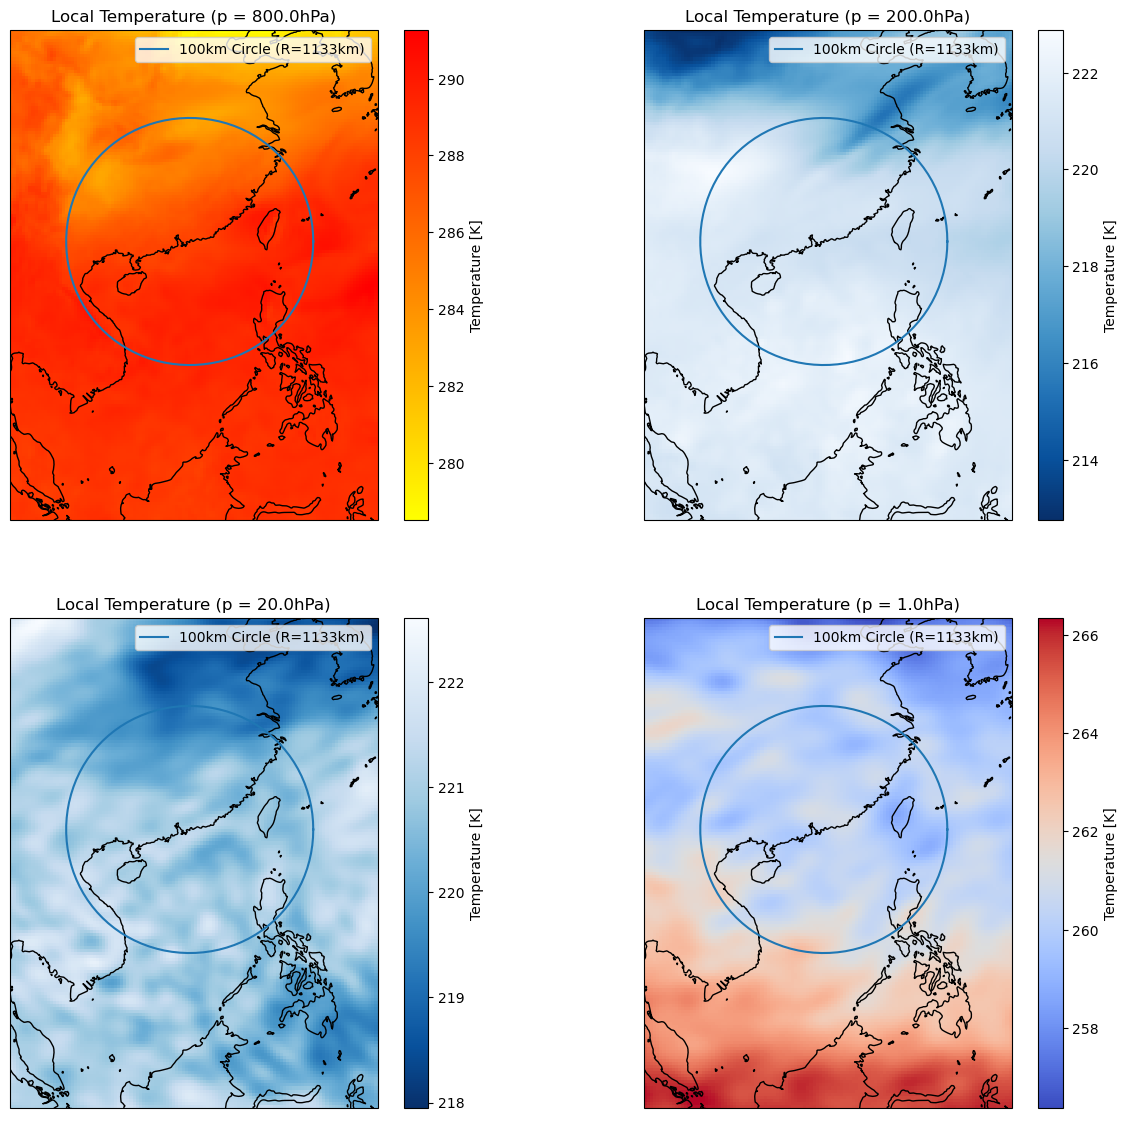

In [169]:
temperature = tempDataSet['t']
print(temperature.latitude)

fig = plt.figure(figsize=(15,14))
axs = []
for i in range(4):
    axs.append(fig.add_subplot(221+i,projection=ccrs.PlateCarree()))
    #axs[i].set_extent([70.,150.,60.,-20.])

temperatureih = temperature.sel(pressure_level = 800,longitude = np.arange(100,130,0.25),latitude=np.arange(0,40,0.25))
temperatureih.plot(ax=axs[0],cmap='autumn_r')
temperatureih = temperature.sel(pressure_level = 200,longitude = np.arange(100,130,0.25),latitude=np.arange(0,40,0.25))
temperatureih.plot(ax=axs[1],cmap='Blues_r')
temperatureih = temperature.sel(pressure_level = 20,longitude = np.arange(100,130,0.25),latitude=np.arange(0,40,0.25))
temperatureih.plot(ax=axs[2],cmap='Blues_r')
temperatureih = temperature.sel(pressure_level = 1,longitude = np.arange(100,130,0.25),latitude=np.arange(0,40,0.25))
temperatureih.plot(ax=axs[3],cmap='coolwarm')
for i,p in enumerate([800.,200.,20.,1]):
    axs[i].set_xlabel('Longitude')
    axs[i].set_ylabel('Latitude')
    axs[i].set_title(f'Local Temperature (p = {p:.1f}hPa)')
    axs[i].add_feature(cfeature.COASTLINE)
    axs[i].plot(xcircle100,ycircle100,label = '100km Circle (R=1133km)')
    axs[i].legend()

##### 图8 100km球冠投影范围内局部分层大气温度不均匀性散点图

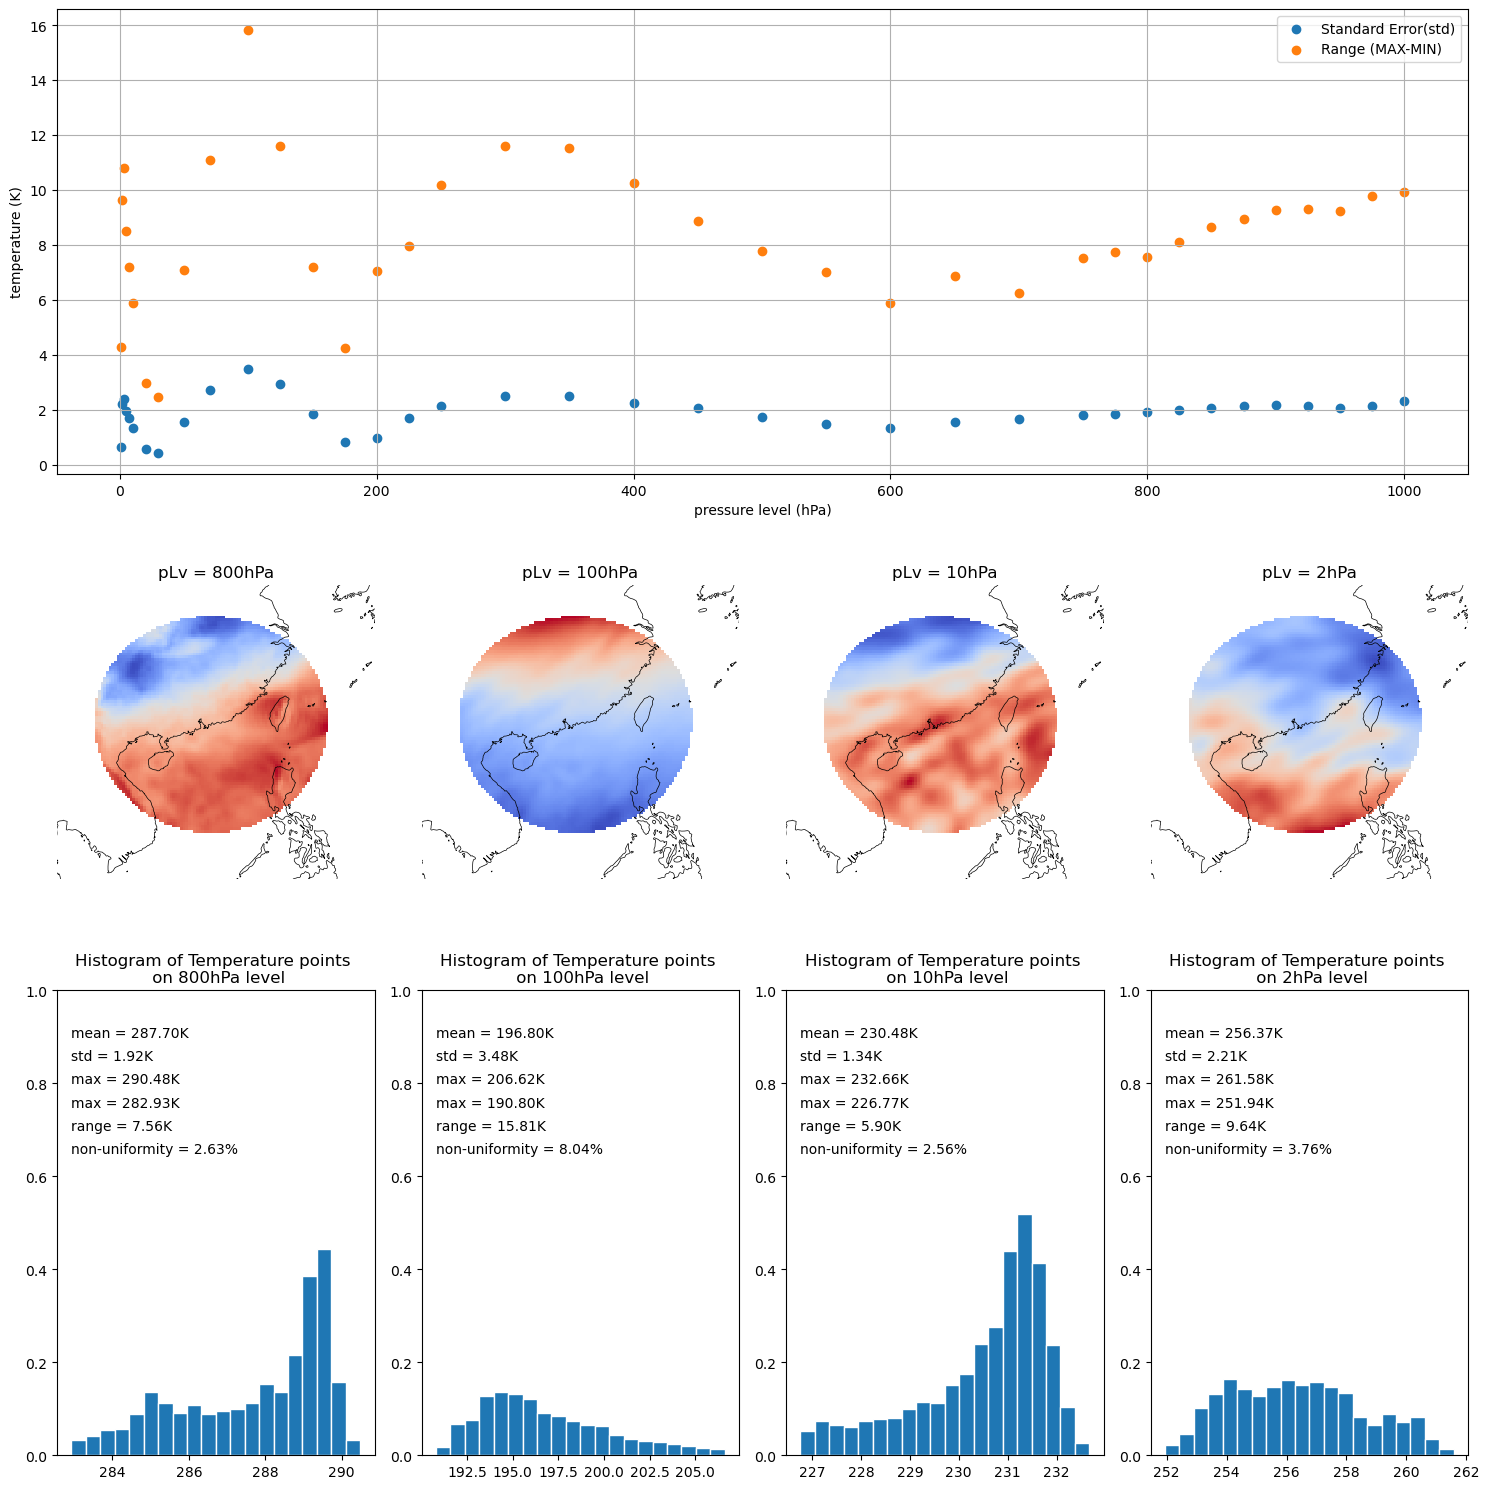

In [260]:
plevels = np.array(temperature['pressure_level'])
latit = np.array(temperature.latitude)
longit = np.array(temperature.longitude)
xgrid,ygrid = np.meshgrid(longit,latit)
points = np.array([xgrid.ravel(),ygrid.ravel()]).T
mask = []
for i,point in enumerate(points):
    mask.append(hDistance(point,MAPEH1) < r100*1e3)
mask = np.array(mask,dtype=bool).reshape(np.shape(xgrid))

result = temperature.where(mask)
stds,ranges = [],[]
for p in plevels:
    r = result.sel(pressure_level = p)
    stds.append(np.std(r))
    ranges.append(np.max(r)-np.min(r))

plt.figure(figsize=(15,15))
ax0 = plt.subplot2grid((3,4),(0,0),rowspan=1,colspan=4)
ax0.scatter(plevels,stds,label = 'Standard Error(std)')
ax0.scatter(plevels,ranges,label = 'Range (MAX-MIN)')
ax0.set_xlabel('pressure level (hPa)')
ax0.set_ylabel('temperature (K)')
ax0.grid()
ax0.legend()

splevels = [800,100,10,2]
for i,p in enumerate(splevels):
    ax1 = plt.subplot2grid((3,4),(1,i),rowspan=1,colspan=1,projection=ccrs.PlateCarree())
    ax1.set_extent([100.,130.,35.,8.])
    r1  = result.sel(pressure_level = p)
    r1.plot(ax=ax1,add_colorbar=False,cmap='coolwarm')
    ax1.set_title(f'pLv = {p}hPa')
    ax1.add_feature(cfeature.COASTLINE,linewidth=0.5)
    ax1.set_frame_on(False)

    ax2 = plt.subplot2grid((3,4),(2,i),rowspan=1,colspan=1)
    ax2.set_ylim(0,1)
    rv1 =r1.values.flatten()
    tup,nar,_= ax2.hist(rv1,edgecolor='w',bins=20,density=True)
    ax2.set_title(f'Histogram of Temperature points \n on {p}hPa level')
    ax2.text(x=nar[0],y=0.9,s = f'mean = {r1.mean():.2f}K')
    ax2.text(x=nar[0],y=0.85,s = f'std = {r1.std():.2f}K')
    ax2.text(x=nar[0],y=0.8,s = f'max = {r1.max():.2f}K')
    ax2.text(x=nar[0],y=0.75,s = f'max = {r1.min():.2f}K')
    ax2.text(x=nar[0],y=0.7,s = f'range = {r1.max()-r1.min():.2f}K')
    ax2.text(x=nar[0],y=0.65,s = f'non-uniformity = {(r1.max()-r1.min())/(r1.mean()):.2%}')

plt.tight_layout()
plt.show()